In [516]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import agent as ag
import model as ml

from matplotlib import style

from df_helpers import get_rows_between, get_outliers
from google_window import WindowGenerator
from model import get_lstm_model
style.use('dark_background')

import importlib
importlib.reload(ag)
importlib.reload(ml)

<module 'model' from 'c:\\Users\\mathi\\Prosjekter\\Vår 2022\\IT3030\\IT3030-Projects\\Project 3\\model.py'>

In [517]:
# Open no1_train.csv and no1_validation.csv
original_df_train = pd.read_csv('no1_train.csv')
original_df_test = pd.read_csv('no1_validation.csv')

# Make copies
df_train = original_df_train.copy()
df_test = original_df_test.copy()

In [518]:
df_train

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
0,2019-01-09 14:10:00,1591.839,141.928,11.5,74.428,0.0,1819.695,341.330021,10.0,-4417.4
1,2019-01-09 14:15:00,1591.839,141.928,11.5,74.428,0.0,1819.695,330.114330,10.0,-4417.4
2,2019-01-09 14:20:00,1591.839,141.928,11.5,74.428,0.0,1819.695,323.877221,10.0,-4417.4
3,2019-01-09 14:25:00,1591.839,141.928,11.5,74.428,0.0,1819.695,296.438463,10.0,-4417.4
4,2019-01-09 14:30:00,1591.839,141.928,11.5,74.428,0.0,1819.695,269.097132,10.0,-4417.4
...,...,...,...,...,...,...,...,...,...,...
225083,2021-03-01 03:05:00,1942.486,191.881,20.1,106.431,0.0,2266.098,141.618915,0.0,-2252.9
225084,2021-03-01 03:10:00,1942.486,191.881,20.1,106.431,0.0,2266.098,129.043820,0.0,-2252.9
225085,2021-03-01 03:15:00,1942.486,191.881,20.1,106.431,0.0,2266.098,94.907548,0.0,-2252.9
225086,2021-03-01 03:20:00,1942.486,191.881,20.1,106.431,0.0,2266.098,102.589040,0.0,-2252.9


In [519]:
df_test.head()

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
0,2021-03-01 03:30:00,1942.49,191.881,20.1,106.431,0.0,2266.102,52.119595,0.0,-2252.9
1,2021-03-01 03:35:00,1942.49,191.881,20.1,106.431,0.0,2266.102,90.374541,0.0,-2252.9
2,2021-03-01 03:40:00,1942.49,191.881,20.1,106.431,0.0,2266.102,88.435063,0.0,-2252.9
3,2021-03-01 03:45:00,1942.49,191.881,20.1,106.431,0.0,2266.102,53.375518,0.0,-2252.9
4,2021-03-01 03:50:00,1942.49,191.881,20.1,106.431,0.0,2266.102,65.496683,0.0,-2252.9


In [520]:
# Convert timestamps in "start_time" to seconds
df_train['start_time_seconds'] = pd.to_datetime(df_train['start_time'])
df_train['start_time_seconds'] = df_train['start_time_seconds'].apply(lambda x: x.timestamp())

# Do the same to df_test
df_test['start_time_seconds'] = pd.to_datetime(df_test['start_time'])
df_test['start_time_seconds'] = df_test['start_time_seconds'].apply(lambda x: x.timestamp())

## Exploratory Data Analysis

First let's look at the data and see if we notice any outliers that might not correlate well with the overall trend of the data

In [521]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hydro,225088.0,1.888334e+03,4.010003e+02,6.834380e+02,1.625029e+03,1.933916e+03,2.175595e+03,2.995524e+03
micro,225088.0,2.241898e+02,5.855985e+01,8.037100e+01,1.850170e+02,2.259380e+02,2.695580e+02,3.492710e+02
thermal,225088.0,2.180350e+01,3.579229e+00,0.000000e+00,2.210000e+01,2.210000e+01,2.410000e+01,2.570000e+01
wind,225088.0,5.570327e+01,4.705303e+01,0.000000e+00,1.570400e+01,4.184800e+01,8.872300e+01,1.760000e+02
river,225088.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
total,225088.0,2.190032e+03,4.440777e+02,8.497320e+02,1.916523e+03,2.248874e+03,2.497792e+03,3.351974e+03
y,225088.0,8.907921e+00,3.202625e+02,-1.579681e+03,-1.422267e+02,-1.128235e+01,1.274549e+02,2.956333e+03
sys_reg,225088.0,-8.284305e+00,4.374831e+01,-8.280000e+02,0.000000e+00,0.000000e+00,0.000000e+00,4.740000e+02
flow,225088.0,-1.999055e+03,1.311682e+03,-5.541200e+03,-2.996700e+03,-1.953700e+03,-9.069000e+02,7.234000e+02
start_time_seconds,225088.0,1.580806e+09,1.949324e+07,1.547043e+09,1.563925e+09,1.580806e+09,1.597688e+09,1.614569e+09


Seeing as river has absolutely all values equal to 0, this is not a good feature to use. We therefore drop it because
it gives no additional information

In [522]:
df_train = df_train.drop(['river'], axis=1)
df_test = df_test.drop(['river'], axis=1)

Let's visualize the data in several plots to see if we instinctively can see anything that doesn't add up

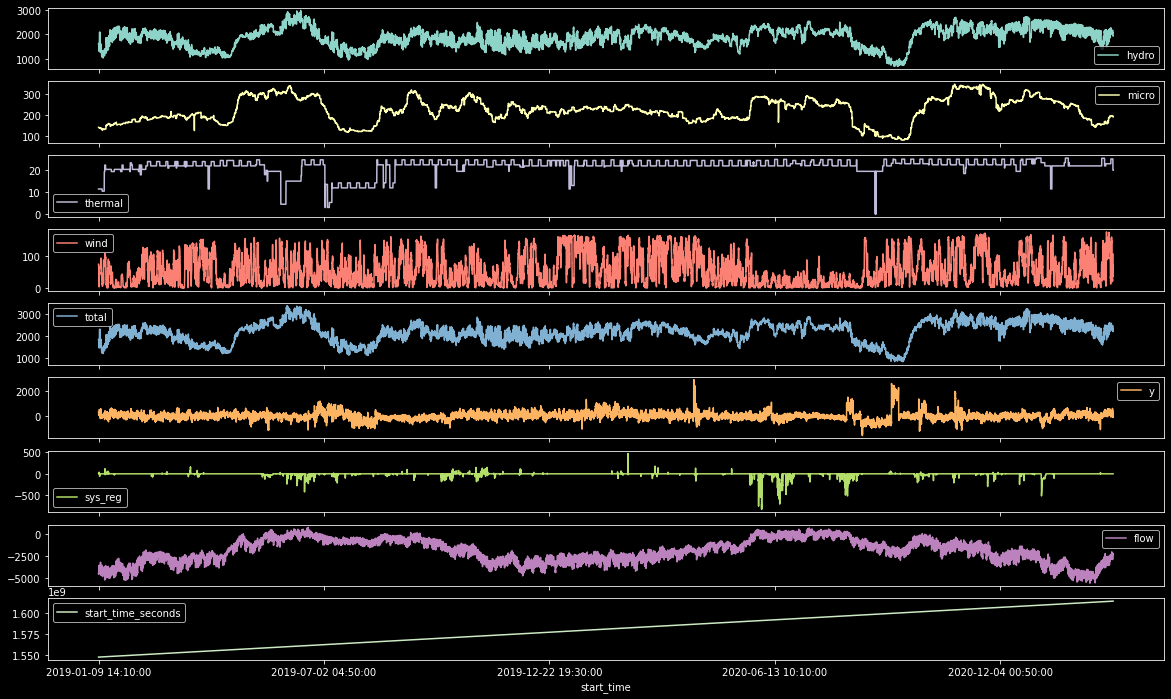

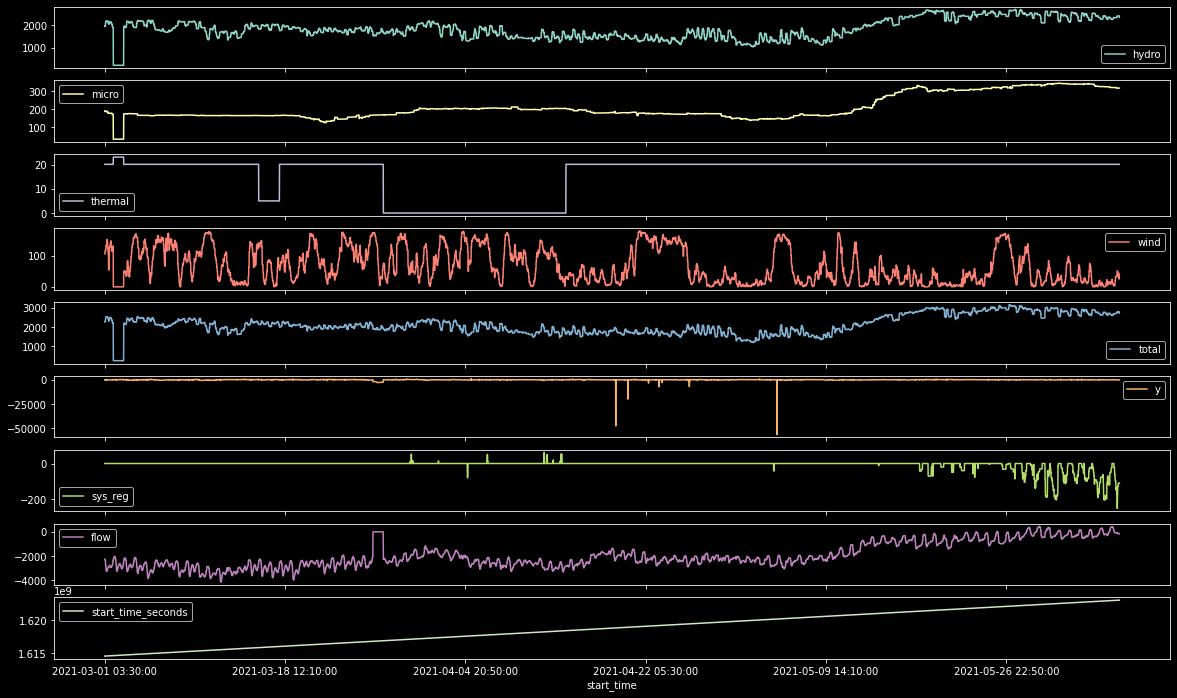

In [523]:
# Get column names from df_train except start_time
cols = df_train.columns.drop('start_time')
plot_features = df_train[cols]
plot_features.index = df_train['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))

# Do the same for df_test
plot_features = df_test.drop("start_time", axis=1)[cols]
plot_features.index = df_test['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))

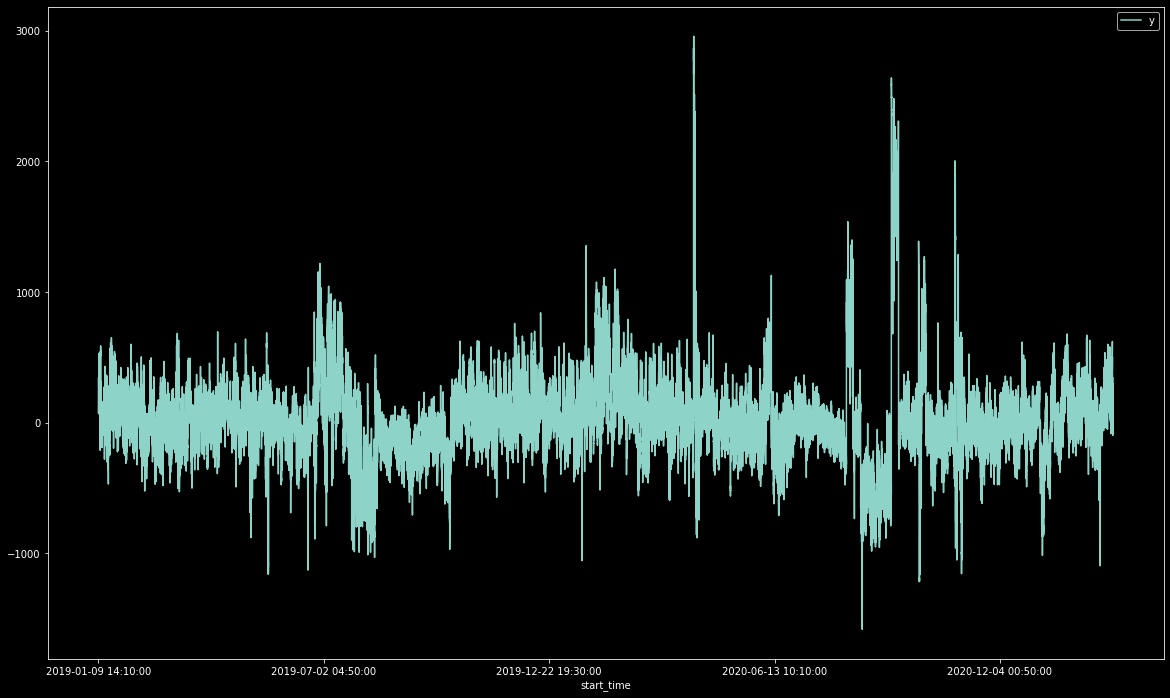

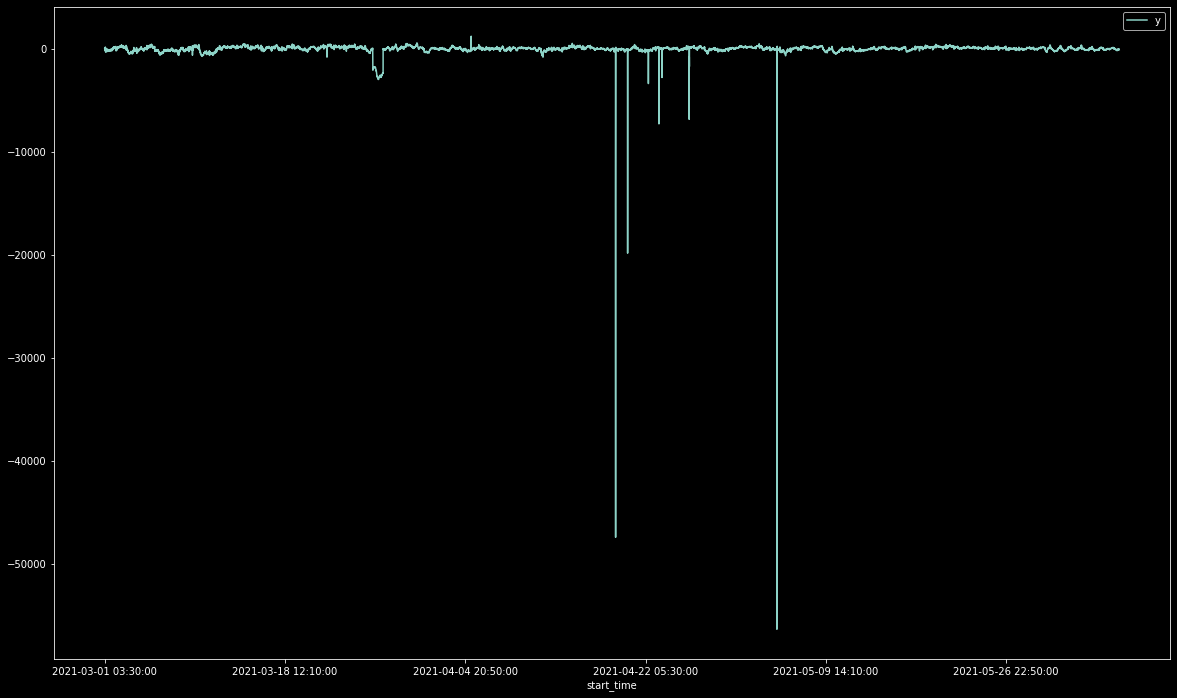

In [524]:
# Plot two different plots; one for df_train, one for df_test with feature "y"
plot_features = df_train[['y']]
plot_features.index = df_train['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))

# Do the same for df_test, but in a new plot 
plot_features = df_test[['y']]
plot_features.index = df_test['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))


There are some spikes in both datasets, especially the validation data, that seem rather inconsistent. Let's replace them with values based on the mean of the "y" value for other datapoints that have similar "total" feature.

In [525]:
df1 = get_rows_between(df_train, 'total', 1500, 1550)
df2 = get_rows_between(df1, 'y', -2900, 2900)
mean_val = df2["y"].mean()
q = (df_train["y"] > 1500) | (df_train["y"] < -1500)
n_clamps = df_train.loc[q].shape[0]
print(f"Percentage of rows clamped in training: {round(n_clamps / df_train.shape[0], 2) * 100}%")
df_train.loc[q, "y"] = mean_val

# Do the same for df_test
df1 = get_rows_between(df_test, 'total', 1500, 1550)
df2 = get_rows_between(df1, 'y', -2900, 2900)
mean_val = df2["y"].mean()
q = (df_test["y"] > 1500) | (df_test["y"] < -1500)
n_clamps = df_test.loc[q].shape[0]
print(f"Percentage of rows clamped in testing: {round(n_clamps / df_test.shape[0], 2) * 100}%")
df_test.loc[q, "y"] = mean_val

Percentage of rows clamped in training: 1.0%
Percentage of rows clamped in testing: 1.0%


Let's see if there are any NaN-values present

In [526]:
# Check for NaN values
df_train.isnull().sum()

start_time            0
hydro                 0
micro                 0
thermal               0
wind                  0
total                 0
y                     0
sys_reg               0
flow                  0
start_time_seconds    0
dtype: int64

## Feature engineering
In this section, we will look at how we can manipulate the data in the dataset in order to better suit it for model prediction. This will include modifying existing features, and introducing new ones.

First we'll implement the required feature: previous_y

Second we'll look at frequencies.
The nature of demand on the power grid is highly dependent on two key factors:
* The time of day
* The time of year

Seeing as the price of electricity has been a heated debate for the past half-year due to environmental and seasonal changes, this might be a good place to start.

In [527]:
day = 24*60*60
year = (365.2425)*day

df_train['Day sin'] = np.sin(df_train['start_time_seconds'] * (2 * np.pi / day))
df_train['Day cos'] = np.cos(df_train['start_time_seconds'] * (2 * np.pi / day))
df_train['Year sin'] = np.sin(df_train['start_time_seconds'] * (2 * np.pi / year))
df_train['Year cos'] = np.cos(df_train['start_time_seconds'] * (2 * np.pi / year))

# Do the same, but for df_test
df_test['Day sin'] = np.sin(df_test['start_time_seconds'] * (2 * np.pi / day))
df_test['Day cos'] = np.cos(df_test['start_time_seconds'] * (2 * np.pi / day))
df_test['Year sin'] = np.sin(df_test['start_time_seconds'] * (2 * np.pi / year))
df_test['Year cos'] = np.cos(df_test['start_time_seconds'] * (2 * np.pi / year))


Let's also add simple bucket-indicators for the time of day since this massively impacts the use of the power grid.
We will use the following buckets for the feature 'time_of_day':

* 0 = early morning. Times between 06:00 and 09:00
* 1 = late morning. Times between 09:00 and 12:00
* 2 = early day. Times between 12:00 and 15:00
* 3 = evening. Times between 15:00 and 18:00
* 4 = late evening. Times between 18:00 and 21:00
* 5 = early night. Times between 21:00 and 00:00
* 6 = night time. Times between 00:00 and 06:00

In [528]:
df_train['hours'] = pd.to_datetime(df_train['start_time']).apply(lambda x: x.hour)
df_train['time_of_day'] = 0
# If time_of_day is between 6 and 8, set it to 0
df_train.loc[(df_train['hours'] >= 6) & (df_train['hours'] <= 8), 'time_of_day'] = 0
# If between 9 and 11, set it to 1
df_train.loc[(df_train['hours'] >= 9) & (df_train['hours'] <= 11), 'time_of_day'] = 1
# If between 12 and 14, set it to 2
df_train.loc[(df_train['hours'] >= 12) & (df_train['hours'] <= 14), 'time_of_day'] = 2
# If between 15 and 17, set it to 3
df_train.loc[(df_train['hours'] >= 15) & (df_train['hours'] <= 17), 'time_of_day'] = 3
# If between 18 and 20, set it to 4
df_train.loc[(df_train['hours'] >= 18) & (df_train['hours'] <= 20), 'time_of_day'] = 4
# If between 21 and 23, set it to 5
df_train.loc[(df_train['hours'] >= 21) & (df_train['hours'] <= 23), 'time_of_day'] = 5
# If between 0 and 5, set it to 6
df_train.loc[(df_train['hours'] >= 0) & (df_train['hours'] <= 5), 'time_of_day'] = 6
df_train.drop(columns='hours', inplace=True)

# Do the same for df_test
df_test['hours'] = pd.to_datetime(df_test['start_time']).apply(lambda x: x.hour)
df_test['time_of_day'] = 0
df_test.loc[(df_test['hours'] >= 6) & (df_test['hours'] <= 8), 'time_of_day'] = 0
df_test.loc[(df_test['hours'] >= 9) & (df_test['hours'] <= 11), 'time_of_day'] = 1
df_test.loc[(df_test['hours'] >= 12) & (df_test['hours'] <= 14), 'time_of_day'] = 2
df_test.loc[(df_test['hours'] >= 15) & (df_test['hours'] <= 17), 'time_of_day'] = 3
df_test.loc[(df_test['hours'] >= 18) & (df_test['hours'] <= 20), 'time_of_day'] = 4
df_test.loc[(df_test['hours'] >= 21) & (df_test['hours'] <= 23), 'time_of_day'] = 5
df_test.loc[(df_test['hours'] >= 0) & (df_test['hours'] <= 5), 'time_of_day'] = 6
df_test.drop(columns='hours', inplace=True)

Now we will apply the same logic for time_of_week, however we will have to use different buckets. We'll simply add one bucket for each day of the week, i.e. 0 for monday, 1 for tuesday, etc..
We will also add an arbitrary feature called 'weekend', which will apply to saturday and sunday (1 for 'weekend' = True, else 0)

In [529]:
df_train['time_of_week'] = pd.to_datetime(df_train['start_time']).apply(lambda x: x.weekday())
# If time_of_week = 5 or 6, set feature 'weekend' to 1. Else set to 0
df_train['weekend'] = 0
df_train.loc[(df_train['time_of_week'] == 5) | (df_train['time_of_week'] == 6), 'weekend'] = 1

# Do the same for df_test
df_test['time_of_week'] = pd.to_datetime(df_test['start_time']).apply(lambda x: x.weekday())
df_test['weekend'] = 0
df_test.loc[(df_test['time_of_week'] == 5) | (df_test['time_of_week'] == 6), 'weekend'] = 1

Finally, we get to time_of_year. Here we will simply use the different months that the dates correspond to. Using this, we will also add a feature called 'season' to explicitly state whether we are in the summer, winter, autumn, or spring.
We will bucket the season as follows using [this](https://snl.no/%C3%A5rstider) definition:

* Spring will go from March through May
* Summer will start in June, and end with (including) August
* Autumn then starts from September, and runs until November
* Finally, winter runs from December through February

In [530]:
df_train['time_of_year'] = pd.to_datetime(df_train['start_time']).apply(lambda x: x.month)
df_train['season'] = 0
# If time_of_year is between 3 and 5, set it to 0
df_train.loc[(df_train['time_of_year'] >= 3) & (df_train['time_of_year'] <= 5), 'season'] = 0
# If between 6 and 8, set it to 1
df_train.loc[(df_train['time_of_year'] >= 6) & (df_train['time_of_year'] <= 8), 'season'] = 1
# If between 9 and 11, set it to 2
df_train.loc[(df_train['time_of_year'] >= 9) & (df_train['time_of_year'] <= 11), 'season'] = 2
# If between 12 and 2, set it to 3
df_train.loc[df_train['time_of_year'] == 12, 'season'] = 3
df_train.loc[df_train['time_of_year'] <= 2, 'season'] = 3

# Do the same for df_test
df_test['time_of_year'] = pd.to_datetime(df_test['start_time']).apply(lambda x: x.month)
df_test['season'] = 0
df_test.loc[(df_test['time_of_year'] >= 3) & (df_test['time_of_year'] <= 5), 'season'] = 0
df_test.loc[(df_test['time_of_year'] >= 6) & (df_test['time_of_year'] <= 8), 'season'] = 1
df_test.loc[(df_test['time_of_year'] >= 9) & (df_test['time_of_year'] <= 11), 'season'] = 2
df_test.loc[df_test['time_of_year'] == 12, 'season'] = 3
df_test.loc[df_test['time_of_year'] <= 2, 'season'] = 3

In [531]:
RESOLUTION = 5
N_PREV = 12
START_INDEX = 12
BATCH_SIZE = 32
TARGET = 'y'
EPOCHS = 1
agent = ag.Agent(
    min_scale=0,
    max_scale=1,
    resolution=RESOLUTION,
    n_prev=N_PREV,
    start_index=START_INDEX,
    batch_size=BATCH_SIZE,
    target=TARGET,
    verbose=True,
    model=get_lstm_model(),
    filepath='./models/LSTM_model_1',
)

Resolution is 5 and n_prev is 12. This is equivalent to looking back 1 hours and 0 minutes. 


In [532]:
df_train.drop(columns=['start_time', 'start_time_seconds'], inplace=True)
df_test.drop(columns=['start_time', 'start_time_seconds'], inplace=True)

In [533]:
agent.fit_scaler(df_train)
df_train = agent.transform_df(df_train)
df_test = agent.transform_df(df_test)
df_train = agent.add_previous_y_to_df(df_train)
df_test = agent.add_previous_y_to_df(df_test)

In [534]:
df_test.head()

,hydro,micro,thermal,wind,total,y,sys_reg,flow,Day sin,Day cos,Year sin,Year cos,time_of_day,time_of_week,weekend,time_of_year,season,previous_y
0,0.544552,0.414689,0.782101,0.604722,0.56604,0.514013,0.635945,0.524902,0.896677,0.804381,0.928225,0.758115,1.0,0.0,0.0,0.181818,0.0,0.000000
1,0.544552,0.414689,0.782101,0.604722,0.56604,0.526857,0.635945,0.524902,0.903222,0.795655,0.928240,0.758089,1.0,0.0,0.0,0.181818,0.0,0.514013
2,0.544552,0.414689,0.782101,0.604722,0.56604,0.526206,0.635945,0.524902,0.909576,0.786788,0.928256,0.758064,1.0,0.0,0.0,0.181818,0.0,0.526857
3,0.544552,0.414689,0.782101,0.604722,0.56604,0.514435,0.635945,0.524902,0.915735,0.777785,0.928271,0.758038,1.0,0.0,0.0,0.181818,0.0,0.526206
4,0.544552,0.414689,0.782101,0.604722,0.56604,0.518504,0.635945,0.524902,0.921696,0.768650,0.928287,0.758013,1.0,0.0,0.0,0.181818,0.0,0.514435


In [535]:
df_train.head()

,hydro,micro,thermal,wind,total,y,sys_reg,flow,Day sin,Day cos,Year sin,Year cos,time_of_day,time_of_week,weekend,time_of_year,season,previous_y
0,0.392892,0.228922,0.447471,0.422886,0.387638,0.611114,0.643625,0.179389,0.231350,0.078304,0.574619,0.994401,0.333333,0.333333,0.0,0.0,1.0,0.000000
1,0.392892,0.228922,0.447471,0.422886,0.387638,0.607348,0.643625,0.179389,0.222215,0.084265,0.574649,0.994396,0.333333,0.333333,0.0,0.0,1.0,0.611114
2,0.392892,0.228922,0.447471,0.422886,0.387638,0.605254,0.643625,0.179389,0.213212,0.090424,0.574678,0.994392,0.333333,0.333333,0.0,0.0,1.0,0.607348
3,0.392892,0.228922,0.447471,0.422886,0.387638,0.596041,0.643625,0.179389,0.204345,0.096778,0.574708,0.994387,0.333333,0.333333,0.0,0.0,1.0,0.605254
4,0.392892,0.228922,0.447471,0.422886,0.387638,0.586862,0.643625,0.179389,0.195619,0.103323,0.574737,0.994383,0.333333,0.333333,0.0,0.0,1.0,0.596041


In [511]:
history = agent.train(df_train, epochs=EPOCHS)


===== CALLING MAKE_DATASET =====
i: 0
i: 10000
i: 20000
i: 30000
i: 40000
i: 50000
i: 60000
i: 70000
i: 80000
i: 90000
i: 100000
i: 110000
i: 120000
i: 130000
i: 140000
i: 150000
i: 160000
i: 170000
i: 180000
i: 190000
i: 200000
i: 210000
i: 220000
Finished making dataset.

7030/7034 [============================>.] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.0285
Epoch 1: saving model to ./models\LSTM_model_1
7034/7034 [==============================] - 88s 12ms/step - loss: 0.0017 - mean_absolute_error: 0.0285


Text(0, 0.5, 'Loss')

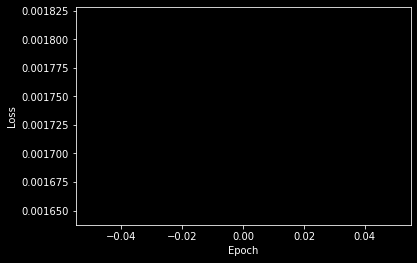

In [512]:
loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [536]:
x_valid = df_test.drop("y", axis=1)
x_valid.head(20)

,hydro,micro,thermal,wind,total,sys_reg,flow,Day sin,Day cos,Year sin,Year cos,time_of_day,time_of_week,weekend,time_of_year,season,previous_y
0,0.544552,0.414689,0.782101,0.604722,0.566040,0.635945,0.524902,0.896677,0.804381,0.928225,0.758115,1.0,0.0,0.0,0.181818,0.0,0.000000
1,0.544552,0.414689,0.782101,0.604722,0.566040,0.635945,0.524902,0.903222,0.795655,0.928240,0.758089,1.0,0.0,0.0,0.181818,0.0,0.514013
2,0.544552,0.414689,0.782101,0.604722,0.566040,0.635945,0.524902,0.909576,0.786788,0.928256,0.758064,1.0,0.0,0.0,0.181818,0.0,0.526857
3,0.544552,0.414689,0.782101,0.604722,0.566040,0.635945,0.524902,0.915735,0.777785,0.928271,0.758038,1.0,0.0,0.0,0.181818,0.0,0.526206
4,0.544552,0.414689,0.782101,0.604722,0.566040,0.635945,0.524902,0.921696,0.768650,0.928287,0.758013,1.0,0.0,0.0,0.181818,0.0,0.514435
5,0.544552,0.414689,0.782101,0.604722,0.566040,0.635945,0.521240,0.927456,0.759387,0.928302,0.757987,1.0,0.0,0.0,0.181818,0.0,0.518504
6,0.559547,0.396943,0.782101,0.662125,0.582026,0.635945,0.512085,0.933013,0.750000,0.928318,0.757961,1.0,0.0,0.0,0.181818,0.0,0.528897
7,0.559547,0.396943,0.782101,0.662125,0.582026,0.635945,0.506593,0.938363,0.740494,0.928333,0.757936,1.0,0.0,0.0,0.181818,0.0,0.499286
8,0.559547,0.396943,0.782101,0.662125,0.582026,0.635945,0.506593,0.943505,0.730874,0.928348,0.757910,1.0,0.0,0.0,0.181818,0.0,0.496880
9,0.559547,0.396943,0.782101,0.662125,0.582026,0.635945,0.506593,0.948436,0.721144,0.928364,0.757885,1.0,0.0,0.0,0.181818,0.0,0.494017



===== CALLING PREDICT_N_TIMESTEPS =====
Prediction for index 12:
0.22911107540130615
Prediction for index 13:
0.23083458840847015
Prediction for index 14:
0.23225615918636322
Prediction for index 15:
0.233380526304245
Prediction for index 16:
0.2343008816242218
Prediction for index 17:
0.23508583009243011
Prediction for index 18:
0.23516467213630676
Prediction for index 19:
0.23507289588451385
Prediction for index 20:
0.2350296676158905
Prediction for index 21:
0.23511533439159393
Prediction for index 22:
0.2353467047214508
Prediction for index 23:
0.23570293188095093
Prediction for index 24:
0.23614871501922607
Prediction for index 25:
0.23681855201721191
Prediction for index 26:
0.23748281598091125
Prediction for index 27:
0.2381288856267929
Prediction for index 28:
0.23874734342098236
Prediction for index 29:
0.2393190562725067
Prediction for index 30:
0.2370726317167282
Prediction for index 31:
0.2354215383529663
Prediction for index 32:
0.23411515355110168
Prediction for index 33

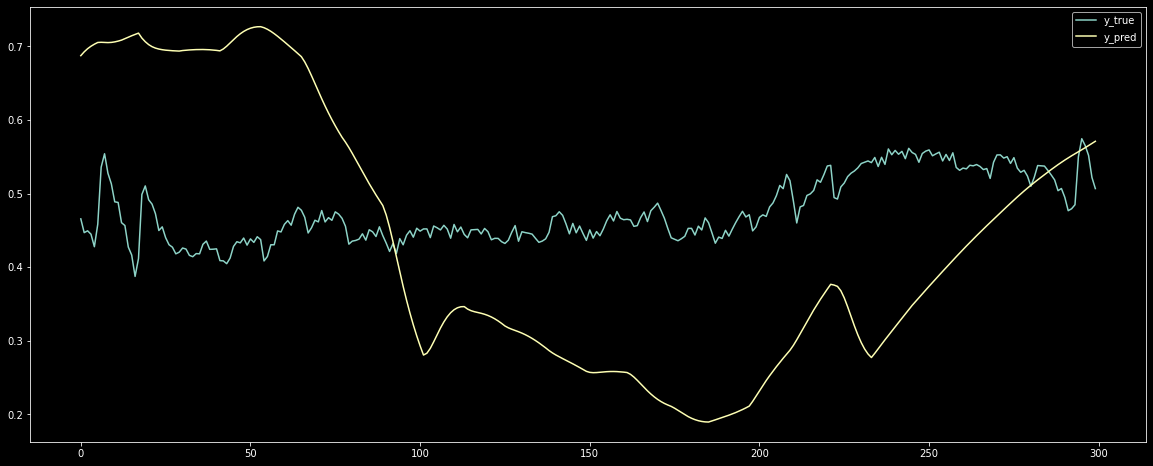

In [537]:
y_pred = agent.predict_n_timesteps(df=x_valid, n_timesteps=300)
agent.visualize_results(df_test[['y']], y_pred, n_timesteps=300)